# Obtener información y datos historicos de IHData GOW 
### Para ello, se utilizará el OpenDAP de IHData

In [1]:
import os
import glob
import xarray as xr
import pandas as pd
import folium
import matplotlib.pyplot as plt
import datetime as dt
from tqdm.notebook import tqdm

#### Buscar nodos mas cercanos a las boyas

In [2]:
df_boyas = pd.read_csv('boyas.csv')
df_boyas

,Nombre,Longitud,Latitud,Cadencia,Codigo,Profundidad,InicioMedida,UltimaMedida,TipoSensor,Modelo,ConjuntoDatos
0,Bilbao-Vizcaya,-3.04,43.64,60,2136,580,07-11-1990,10-07-2024,Direccional Met-Oce,SeaWatch,REDEXT
1,Cabo_de_Pennas,-6.18,43.75,60,2242,615,09-06-1998,10-07-2024,Direccional Met-Oce,SeaWatch,REDEXT
2,Estaca_de_Bares,-7.68,44.12,60,2244,1800,19-07-1996,10-07-2024,Direccional Met-Oce,SeaWatch,REDEXT
3,Villano-Sisargas,-9.21,43.80,60,2246,386,12-05-1998,10-07-2024,Direccional Met-Oce,SeaWatch,REDEXT
4,Cabo_Silleiro,-9.43,42.12,60,2248,600,06-07-1998,23-04-2020,Direccional Met-Oce,SeaWatch,REDEXT
5,Golfo_de_Cadiz,-6.96,36.49,60,2342,450,27-08-1996,10-07-2024,Direccional Met-Oce,SeaWatch,REDEXT
6,Alboran,-5.03,36.27,60,2542,530,17-02-1997,25-02-2016,Direccional Met-Oce,SeaWatch,REDEXT
7,Cabo_de_Gata,-2.34,36.57,60,2548,536,27-03-1998,10-07-2024,Direccional Met-Oce,SeaWatch,REDEXT
8,Cabo_de_Palos,-0.31,37.65,60,2610,230,18-07-2006,03-04-2020,Direccional Met-Oce,SeaWatch,REDEXT
9,Valencia,-0.20,39.51,60,2630,260,15-09-2005,15-06-2020,Direccional Met-Oce,SeaWatch,REDEXT


In [ ]:
def sort_by_year_month(file_names):
    # Función para extraer año y mes de cada nombre
    def get_year_month(file_name):
        parts = file_name.split('_')[-1]  # Obtenemos la parte después del primer '_'
        year, month = parts.split('.')[0], parts.split('.')[1]
        return dt.datetime.strptime(f"{year}-{month}", "%Y-%m")

    # Ordenar usando la función get_year_month como clave
    return sorted(file_names, key=get_year_month)

In [ ]:
path = r'\\193.144.213.171\ihcantabria\GOW\GOW_CFS\Europa'
files = glob.glob(os.path.join(path, 'GOW_CFS_Europa_*.nc'))
files = [f for f in files if 'Mask' not in f]
files = sort_by_year_month(files)
for nombre, lat, lon in zip(df_boyas.Nombre[:-2], df_boyas.Latitud[:-2], df_boyas.Longitud[:-2]):
    print(nombre, lat, lon)
    data_res = xr.Dataset()
    for i, f in tqdm(enumerate(files), total=len(files)):
        data = xr.open_dataset(os.path.join(path, f))
        data_c = data.sel(latitude=lat, longitude=lon, method="nearest")     
        if i == 0:
            data_res = data_c
        else:
            data_res = xr.concat([data_res, data_c], dim="time")
    data_res.to_netcdf(f'data/raw/historico/GOW_CFS_{nombre}.nc')

In [ ]:
path = r'\\193.144.213.171\ihcantabria\GOW\GOW_CFS\Canarias'
files = glob.glob(os.path.join(path, 'GOW_CFS_Canarias_*.nc'))
files = [f for f in files if 'Mask' not in f]
files = sort_by_year_month(files)
for nombre, lat, lon in zip(df_boyas.Nombre[-2:], df_boyas.Latitud[-2:], df_boyas.Longitud[-2:]):
    print(nombre, lat, lon)
    data_res = xr.Dataset()
    for i, f in tqdm(enumerate(files), total=len(files)):
        data = xr.open_dataset(os.path.join(path, f))
        data_c = data.sel(latitude=lat, longitude=lon, method="nearest")     
        if i == 0:
            data_res = data_c
        else:
            data_res = xr.concat([data_res, data_c], dim="time")
    data_res.to_netcdf(f'data/raw/historico/GOW_CFS_{nombre}.nc')

In [11]:
df_hindcast = pd.DataFrame(columns=['Nombre', 'Longitud', 'Latitud', 'InicioMedida', 'FinMedida'])
for nombre, lat, lon in zip(df_boyas.Nombre, df_boyas.Latitud, df_boyas.Longitud):  
    ds = xr.open_dataset(os.path.join(f'data/raw/historico/GOW_CFS_{nombre}.nc'))
    df_hindcast.loc[len(df_hindcast.index)] = [nombre, ds.longitude.values, ds.latitude.values, ds.time.values[0], ds.time.values[-1]]
df_hindcast

,Nombre,Longitud,Latitud,InicioMedida,FinMedida
0,Bilbao-Vizcaya,-3.0,43.625,1979-01-01,2019-03-31 23:00:00.000013440
1,Cabo_de_Pennas,-6.125,43.75,1979-01-01,2019-03-31 23:00:00.000013440
2,Estaca_de_Bares,-7.625,44.125,1979-01-01,2019-03-31 23:00:00.000013440
3,Villano-Sisargas,-9.25,43.75,1979-01-01,2019-03-31 23:00:00.000013440
4,Cabo_Silleiro,-9.375,42.125,1979-01-01,2019-03-31 23:00:00.000013440
5,Golfo_de_Cadiz,-7.0,36.5,1979-01-01,2019-03-31 23:00:00.000013440
6,Alboran,-5.0,36.25,1979-01-01,2019-03-31 23:00:00.000013440
7,Cabo_de_Gata,-2.375,36.625,1979-01-01,2019-03-31 23:00:00.000013440
8,Cabo_de_Palos,-0.25,37.625,1979-01-01,2019-03-31 23:00:00.000013440
9,Valencia,-0.25,39.5,1979-01-01,2019-03-31 23:00:00.000013440


In [7]:
m = folium.Map(location=(39, -5), zoom_start=5)
for i in range(len(df_hindcast)):
    folium.Marker(location=[df_boyas.Latitud[i], df_boyas.Longitud[i]], icon=folium.Icon(color='black')).add_to(m)
    
    folium.Marker(location=[df_hindcast.Latitud[i], df_hindcast.Longitud[i]], tooltip=folium.Tooltip(df_hindcast.Nombre[i], permanent=True)).add_to(m)
m

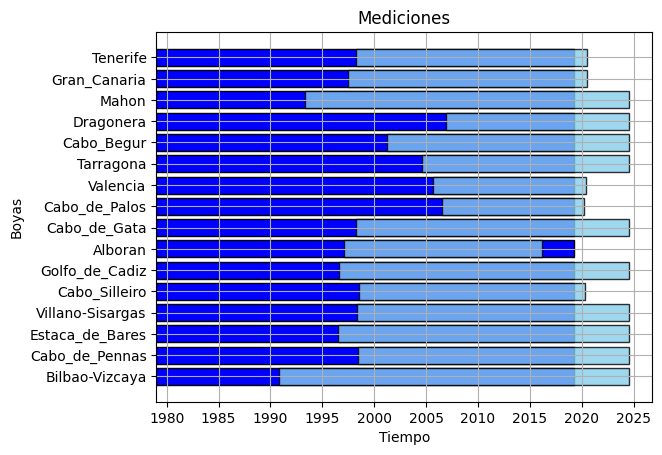

In [12]:
fig, ax = plt.subplots()
for i, task in df_boyas.iterrows():   
    start = dt.datetime.strptime('01-01-1979', '%d-%m-%Y')
    finish = dt.datetime.strptime('31-03-2019', '%d-%m-%Y')
    ax.barh(df_hindcast.loc[i]['Nombre'], (finish - start).days, left=start, color='blue', edgecolor='black')
    
    start = dt.datetime.strptime(task['InicioMedida'], '%d-%m-%Y')
    finish = dt.datetime.strptime(task['UltimaMedida'], '%d-%m-%Y')
    ax.barh(task['Nombre'], (finish - start).days, left=start, color='skyblue', edgecolor='black', alpha=0.8)
ax.set_xlabel('Tiempo')
ax.set_ylabel('Boyas')
ax.set_title('Mediciones')
plt.gca().set_facecolor("white")
ax.grid(True)

#### Explorar datos

In [ ]:
data = xr.open_dataset(f'data/raw/historico/GOW_CFS_Bilbao-Vizcaya.nc')
df_var = pd.DataFrame(columns=['Variable', 'Unidades', 'Descripción'])
for var in data.variables:
    standard_name = data[var].standard_name if hasattr(data[var], 'standard_name') else '****'
    units = data[var].units if hasattr(data[var], 'units') else '****'
    df_var.loc[len(df_var.index)] = [var, units, standard_name]
df_var